In [29]:
import xarray as xr
from dask.distributed import Client
import time
import datetime as dt
import warnings
warnings.filterwarnings('ignore')
import sys
import gc
import numpy as np
sys.setrecursionlimit(100000)

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as colors
import scipy.io as sio
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
import seaborn as sns
import cmaps
import seapy

In [62]:

#define your observation, forward simulation and da simulation root path
myobsroot = '/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS/'
mynlroot = '/Volumes/WD_3/outputs_SCORRECTION/'
mypriorroot = '/Volumes/WD_3/roms4dvar_ecs/i4dvar_outputs/'
mypostroot = '/Volumes/WD_3/roms4dvar_ecs/i4dvar_outputs/'
#define your workspace 
nl_workspace = 'outputs_201205/'
prior_workspace = 'workspace_sstbgqc/'
post_workspace = 'workspace_withcruise/'
obs_workspace = ''
#define your filenames
obs_file='sst_withcruisepkodc_2012_offshore.nc'
nl_files = "ocean_ecs_avg_0372.nc"
#since this is a vertical profile validation, full fwd file is needed
prior_files = "STORAGE/posterior/ocean_ecs_fwd_1546*_outer1.nc"
posterior_files = "STORAGE/posterior/ocean_ecs_fwd_1546*_outer1.nc"

#
grd_file = '/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/workspace_geopolarsst/STORAGE/prior/ocean_ecs_fwd_15461_outer0.nc'

In [63]:
#define your target data duration

start_date = '2012-05-01-12H'
end_date = '2012-05-10-12H'

start_datetime = dt.datetime.strptime(start_date,"%Y-%m-%d-%HH")
end_datetime = dt.datetime.strptime(end_date,"%Y-%m-%d-%HH")
data_len = (end_datetime-start_datetime).days+1 

#define your target variable
obs_var = 6
# 2d situation
model_var = 'temp' 
#3d situation
# model_var = 'temp'

# setting chunk size
x_chunk = int(262/2)
y_chunk = int(362/2)
z_chunk = 10

print('''duration to be validated: from %s to %s, total of %i days.
         target obs variable: %s
         target model variable: %s'''
      %(start_date,end_date,data_len,obs_var,model_var))




duration to be validated: from 2012-05-01-12H to 2012-05-10-12H, total of 10 days.
         target obs variable: 6
         target model variable: temp


In [64]:
# loading observation data
# differ from sst data
# cruise data are extracted from observation file in 4dvar format
# so the extract process is difference
Obs_ds = xr.open_dataset(myobsroot+obs_workspace+obs_file,
                           engine='netcdf4',
                          )


In [49]:
obs_all_provenance = Obs_ds.obs_provenance.data[:]
obs_all_time = Obs_ds.obs_time.data[:]

In [6]:
obs_all_timestamp = np.array([ dt.timedelta(itime) + dt.datetime(1970,1,1) for itime in obs_all_time])


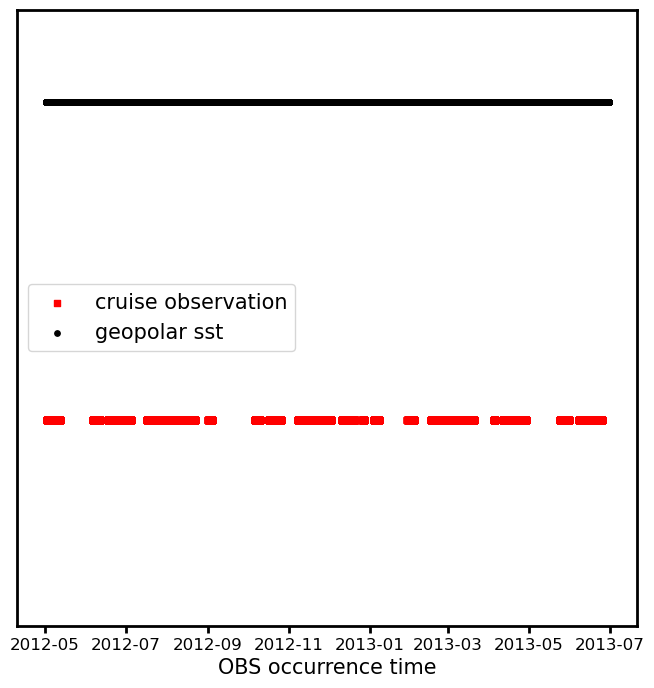

In [7]:
plt.style.use('default')
fig,ax = plt.subplots(figsize = (8,8))
for bnd in ax.spines.keys():
    ax.spines[bnd].set_linewidth('2')
ax.scatter(obs_all_timestamp[obs_all_provenance==200],obs_all_provenance[obs_all_provenance==200],15,color='r',marker='s',label='cruise observation')
ax.scatter(obs_all_timestamp[obs_all_provenance==355],obs_all_provenance[obs_all_provenance==355],15,color='k',marker='o',label='geopolar sst')
ax.tick_params(direction = 'out',width =2,length=5, labelsize = 12,top = 0, right = 0,left=0)
ax.tick_params('y',labelleft=False)
ax.set_xlabel('OBS occurrence time',fontsize=15)
ax.set_ylim([100,400])
ax.legend(loc='center left',fontsize=15)
plt.savefig('/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS/obs_occurence.jpeg',bbox_inches='tight',dpi=400)

In [65]:
# extracting cruise observation data with specific time range 
start_obstime = (start_datetime - dt.datetime(1970,1,1)).total_seconds()/3600/24
end_obstime = (end_datetime - dt.datetime(1970,1,1)).total_seconds()/3600/24

this_range = np.where( 
                                (Obs_ds.obs_time.data >= start_obstime) &
                                (Obs_ds.obs_time.data <= end_obstime)  &
                                (Obs_ds.obs_provenance == 200)&
                                (Obs_ds.obs_type == obs_var)
                        )

Obs_time = Obs_ds.obs_time[this_range].data[:]
Obs_data = Obs_ds.obs_value[this_range].data[:]
Obs_depth = Obs_ds.obs_depth[this_range].data[:]
Obs_lon = Obs_ds.obs_lon[this_range].data[:]
Obs_lat = Obs_ds.obs_lat[this_range].data[:]
Obs_x = Obs_ds.obs_Xgrid[this_range].data[:]
Obs_y = Obs_ds.obs_Ygrid[this_range].data[:]
# Obs_data = Obs_data
# Obs_data


In [34]:
end_datetime

datetime.datetime(2012, 5, 10, 12, 0)

In [35]:
# loading forward sst
start = time.time()
fwd_ds = xr.open_mfdataset(mynlroot+nl_workspace+nl_files,
                                      engine='netcdf4',coords='minimal',
                                      parallel=True,
                                      # chunks={'eta_rho':y_chunk,'xi_rho':x_chunk,
                                      #      's_rho':z_chunk, # only 3d needed
                                      #      'eta_u':y_chunk,'xi_u':x_chunk,\
                                      #      'eta_v':y_chunk,'xi_v':x_chunk,\
                                      #      'eta_psi':y_chunk,'xi_psi':x_chunk,},
                                       )#.chunk(dict(ocean_time=-1))
end = time.time()
print('loading costing %f min'%((end-start)/60))


loading costing 0.042536 min


In [36]:
fwd_time = fwd_ds.ocean_time.data.astype(float)/3600/24*1e-9

In [25]:
mydaroot+prior_workspace+prior_files

'/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/workspace_withcruise/STORAGE/prior/ocean_ecs_fwd_15461_outer0.nc'

In [37]:
# loading prior sst
start = time.time()
prior_ds = xr.open_mfdataset(mypriorroot+prior_workspace+prior_files,
                             engine='netcdf4',coords='minimal',
                             parallel=True,
                             # chunks={'eta_rho':y_chunk,'xi_rho':x_chunk,
                             #             # 's_rho':z_chunk, # only 3d needed
                             #               'eta_u':y_chunk,'xi_u':x_chunk,\
                             #               'eta_v':y_chunk,'xi_v':x_chunk,\
                             #               'eta_psi':y_chunk,'xi_psi':x_chunk,},
                            )#.chunk(dict(ocean_time=-1))
end = time.time()
print('loading costing %f min'%((end-start)/60))



loading costing 0.048469 min


In [38]:
prior_time = prior_ds.ocean_time.data.astype(float)/3600/24*1e-9

In [39]:
# loading poseterior sst
start = time.time()
post_ds = xr.open_mfdataset(mypostroot+post_workspace+posterior_files,
                                 engine='netcdf4',coords='minimal',
                                 parallel=True,
                                 # chunks={'eta_rho':y_chunk,'xi_rho':x_chunk,
                                 #         # 's_rho':z_chunk, # only 3d needed
                                 #           'eta_u':y_chunk,'xi_u':x_chunk,\
                                 #           'eta_v':y_chunk,'xi_v':x_chunk,\
                                 #           'eta_psi':y_chunk,'xi_psi':x_chunk,},
                                )#.chunk(dict(ocean_time=-1))

end = time.time()
print('loading costing %f min'%((end-start)/60))



loading costing 0.046741 min


In [40]:
post_time = post_ds.ocean_time.data.astype(float)/3600/24*1e-9

In [41]:
my_div_color = np.array(  [
                 [0,0,123],
                [9,32,154],
                [22,58,179],
                [34,84,204],
                [47,109,230],
                [63,135,247],
                [95,160,248],
                [137,186,249],
                [182,213,251],
                [228,240,254],
                [255,255,255],
                [250,224,224],
                [242,164,162],
                [237,117,113],
                [235,76,67],
                [233,52,37],
                [212,45,31],
                [188,39,26],
                [164,33,21],
                [140,26,17],
                [117,20,12]
                ])/255
my_div = LinearSegmentedColormap.from_list('div',my_div_color, N = 256)


In [ ]:
np.array(list(set(tuple(zip(np.round(Obs_lon,8),,8))))))np.round(Obs_lat

In [66]:

ip = 0
for iobstime in np.unique(Obs_time):
    thistime = np.where(Obs_time == iobstime)
    
    
   
    for ipos in np.array(list(set(tuple(zip(np.round(Obs_lon[thistime],8),np.round(Obs_lat[thistime],8)))))):
        # print(ipos)
        thispos = np.where( (np.round(Obs_lon[thistime],8)==ipos[0]) & (np.round(Obs_lat[thistime],8)==ipos[1]))
    
    
        obs_profile = Obs_data[thistime][thispos]
        x_thispos = int(np.round(Obs_x[thistime][thispos][0]))
        lon_thispos = ipos[0]
        # print(x_thispos,lon_thispos)
        y_thispos = int(np.round(Obs_y[thistime][thispos][0]))
        lat_thispos = ipos[1]
        # print(y_thispos,lat_thispos)
        if ip == 0:
            lon_obs = ipos[0]
            lat_obs = ipos[1]
        else:
            lon_obs = np.r_[lon_obs,ipos[0]]
            lat_obs = np.c_[lat_obs,ipos[1]]
        ip+=1

In [67]:
plt.style.use('seaborn')
plt.style.use('seaborn-whitegrid')
my_palette = sns.color_palette(my_div_color[5:-5])
ip = 0
for iobstime in np.unique(Obs_time):
    thistime = np.where(Obs_time == iobstime)
    print('OBS TIME:',(dt.timedelta(iobstime)+dt.datetime(1970,1,1)).strftime('%Y-%m-%d %H:%M'))
    fwd_tindex = np.argmin(np.abs(fwd_time-iobstime))
    da_tindex = np.argmin(np.abs(prior_time-iobstime))
    
    fwddata_thistime = fwd_ds[model_var].isel(ocean_time=fwd_tindex).data.compute()
    print('FWD TIME:',(dt.timedelta(fwd_time[fwd_tindex])+dt.datetime(1970,1,1)).strftime('%Y-%m-%d %H:%M'))
    fwdzeta_thistime = fwd_ds['zeta'].isel(ocean_time=fwd_tindex).data.compute()
    
    
    priordata_thistime = prior_ds[model_var].isel(ocean_time=da_tindex).data.compute()
    priorzeta_thistime = fwd_ds['zeta'].isel(ocean_time=da_tindex).data.compute()
    
    print('DA TIME:',(dt.timedelta(prior_time[da_tindex])+dt.datetime(1970,1,1)).strftime('%Y-%m-%d %H:%M'))
    postdata_thistime = post_ds[model_var].isel(ocean_time=da_tindex).data.compute()
    postzeta_thistime = post_ds['zeta'].isel(ocean_time=da_tindex).data.compute()
    
    fwdgrid = seapy.model.asgrid(grd_file); fwdgrid.zeta = fwdzeta_thistime;fwdgrid = seapy.model.asgrid(fwdgrid)
    priorgrid = seapy.model.asgrid(grd_file); priorgrid.zeta = priorzeta_thistime;priorgrid = seapy.model.asgrid(priorgrid)
    postgrid = seapy.model.asgrid(grd_file); postgrid.zeta = postzeta_thistime;postgrid = seapy.model.asgrid(postgrid)
    
    for ipos in np.array(list(set(tuple(zip(np.round(Obs_lon[thistime],8),np.round(Obs_lat[thistime],8)))))):
        print(ipos)
        thispos = np.where( (np.round(Obs_lon[thistime],8)==ipos[0]) & (np.round(Obs_lat[thistime],8)==ipos[1]))
    
    
        obs_profile = Obs_data[thistime][thispos]
        x_thispos = int(np.round(Obs_x[thistime][thispos][0]))
        lon_thispos = ipos[0]
        # print(x_thispos,lon_thispos)
        y_thispos = int(np.round(Obs_y[thistime][thispos][0]))
        lat_thispos = ipos[1]
        # print(y_thispos,lat_thispos)
        depth_intplevel = np.arange(-200,1,1)
        obs_intplevel = np.interp(depth_intplevel,Obs_depth[thistime][thispos],obs_profile,left=np.nan,right=np.nan)
        
        print('\tOBS POS:', 'LON:', lon_thispos, 'LAT:', lat_thispos)
    
        print('\tMOD POS:', 'LON:',fwd_ds.lon_rho.data.compute()[y_thispos,x_thispos],
                          'LAT:',fwd_ds.lat_rho.data.compute()[y_thispos,x_thispos])
        print('\tMOD POS:', 'X:  ', x_thispos, 'Y:  ', y_thispos)
    

        fwd_intplevel = np.interp(depth_intplevel,fwdgrid.depth_rho[:,y_thispos,x_thispos],fwddata_thistime[:,y_thispos,x_thispos],left=np.nan,right=np.nan)
        prior_intplevel = np.interp(depth_intplevel,priorgrid.depth_rho[:,y_thispos,x_thispos],priordata_thistime[:,y_thispos,x_thispos],left=np.nan,right=np.nan)
        post_intplevel = np.interp(depth_intplevel,postgrid.depth_rho[:,y_thispos,x_thispos],postdata_thistime[:,y_thispos,x_thispos],left=np.nan,right=np.nan)
        if ip == 0:
            Obs_profiles = obs_intplevel.copy()
            Fwd_profiles = fwd_intplevel.copy()
            Prior_profiles = prior_intplevel.copy()
            Post_profiles = post_intplevel.copy()
            Fwd_errs = fwd_intplevel - obs_intplevel
            Prior_errs = prior_intplevel - obs_intplevel
            Post_errs = post_intplevel - obs_intplevel
        else:
            Obs_profiles = np.c_[Obs_profiles,obs_intplevel.copy()]
            Fwd_profiles = np.c_[Fwd_profiles,fwd_intplevel.copy()]
            Prior_profiles = np.c_[Prior_profiles,prior_intplevel.copy()]
            Post_profiles = np.c_[Post_profiles,post_intplevel.copy()]
            Fwd_errs = np.c_[Fwd_errs,fwd_intplevel - obs_intplevel]
            Prior_errs = np.c_[Prior_errs,prior_intplevel - obs_intplevel]
            Post_errs = np.c_[Post_errs,post_intplevel - obs_intplevel]
        
        ip+=1
            
        fig,ax = plt.subplots(figsize = (4,8))
    
        ax.plot(obs_profile,Obs_depth[thistime][thispos],'o-',color='k',label='cruise obs')
        # ax.plot(fwd_profile[1:],depth_modlevel[1:],color=my_palette[-1], label='forward',)
        ax.plot(fwd_intplevel,depth_intplevel,'.-',color=my_palette[0], label='NL ROMSv4.1',)
    
    
        # ax.plot(prior_profile[1:],depth_modlevel[1:],color=my_palette[7],label='prior',)
        ax.plot(prior_intplevel,depth_intplevel,'.-',color=my_palette[7],label='DA_SST ROMSv4.1',)
        # ax.plot(post_profile[1:],depth_modlevel[1:],color=my_palette[0],label='posterior',)
        ax.plot(post_intplevel,depth_intplevel,'.-',color=my_palette[-1],label='DA_ALL ROMSv4.1',)
        ax.legend(loc='upper left',fontsize=12)
        ax.set_ylabel('depth/m')
        ax.set_xlabel('temp/$\degree$C')
        ax.set_title('OBS TIME = %s \n LON: %s LAT: %s'%((dt.timedelta(iobstime)+dt.datetime(1970,1,1)).strftime('%Y-%m-%d %H:%M'),
                                                np.round(lon_thispos,2),
                                                np.round(lat_thispos,2)))
        plt.savefig('./fig_profile_versus/%s_profile.jpeg'%((dt.timedelta(iobstime)+dt.datetime(1970,1,1)).strftime('%Y-%m-%d %H_%M')),bbox_inches='tight',dpi=400)
        plt.close()
    del fwddata_thistime
    del fwdzeta_thistime
    del priordata_thistime
    del priorzeta_thistime
    del postdata_thistime
    del postzeta_thistime
    del fwdgrid
    del priorgrid
    del postgrid
    gc.collect()

OBS TIME: 2012-05-02 07:48
FWD TIME: 2012-05-02 07:30
DA TIME: 2012-05-02 08:00
[122.42458803  31.27411899]
	OBS POS: LON: 122.42458803 LAT: 31.27411899
	MOD POS: LON: 122.41741821107213 LAT: 31.28632052937131
	MOD POS: X:   67 Y:   153
OBS TIME: 2012-05-02 12:43
FWD TIME: 2012-05-02 12:30
DA TIME: 2012-05-02 13:00
[123.09839872  31.2746042 ]
	OBS POS: LON: 123.09839872 LAT: 31.2746042
	MOD POS: LON: 123.0914767700736 LAT: 31.27314190226044
	MOD POS: X:   85 Y:   152
OBS TIME: 2012-05-02 18:12
FWD TIME: 2012-05-02 18:30
DA TIME: 2012-05-02 18:00
[123.90987608  31.27714609]
	OBS POS: LON: 123.90987608 LAT: 31.27714609
	MOD POS: LON: 123.92036342698968 LAT: 31.26937526712205
	MOD POS: X:   106 Y:   151
OBS TIME: 2012-05-02 22:11
FWD TIME: 2012-05-02 22:30
DA TIME: 2012-05-02 22:00
[124.54787516  31.27392369]
	OBS POS: LON: 124.54787516 LAT: 31.27392369
	MOD POS: LON: 124.53588998041961 LAT: 31.263069991196048
	MOD POS: X:   121 Y:   150
OBS TIME: 2012-05-03 02:40
FWD TIME: 2012-05-03 02:

IndexError: index 201 is out of bounds for axis 0 with size 200

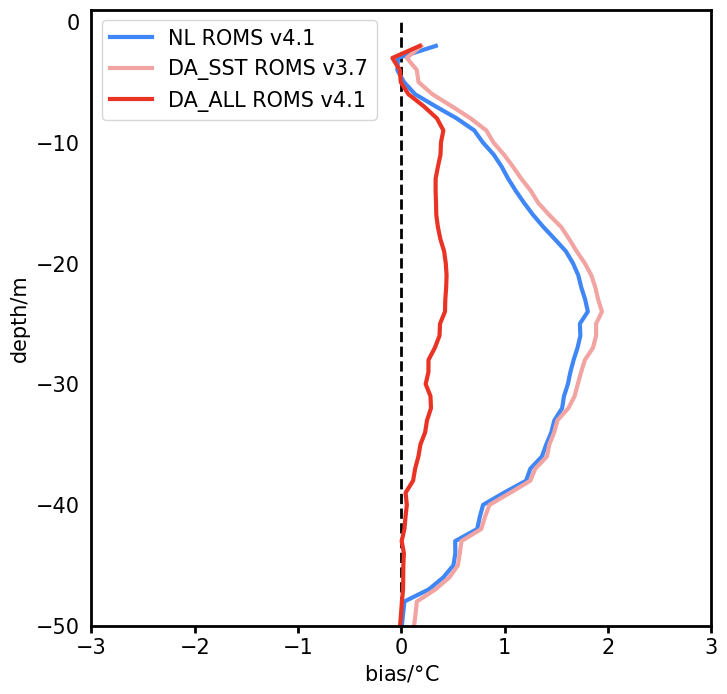

In [53]:
plt.style.use('default')
fig,ax = plt.subplots(figsize = (8,8))
for bnd in ax.spines.keys():
    ax.spines[bnd].set_linewidth('2')
ax.plot(np.nanmean(Fwd_errs,axis=1),depth_intplevel,color=my_palette[0], linewidth=3,label='NL ROMS v4.1',zorder=2)
ax.plot(np.nanmean(Prior_errs,axis=1),depth_intplevel,color=my_palette[7],linewidth=3,label='DA_SST ROMS v3.7',zorder=2)
ax.plot(np.nanmean(Post_errs,axis=1),depth_intplevel,color=my_palette[-1],linewidth=3,label='DA_ALL ROMS v4.1',zorder=2)
ax.plot(np.zeros_like(depth_intplevel),depth_intplevel,'--',color='k',linewidth=2,zorder=1)
ax.set_xlim([-3,3])
ax.set_ylim([-50,1])
ax.legend(loc='upper left',fontsize=15)
ax.set_ylabel('depth/m',fontsize=15)
ax.set_xlabel('bias/$\degree$C',fontsize=15)
ax.tick_params(direction = 'out',width =2,length=5, labelsize = 15,top = 0, right = 0,left=0)
# plt.savefig('/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS/dasst_bias.jpeg',bbox_inches='tight',dpi=400)

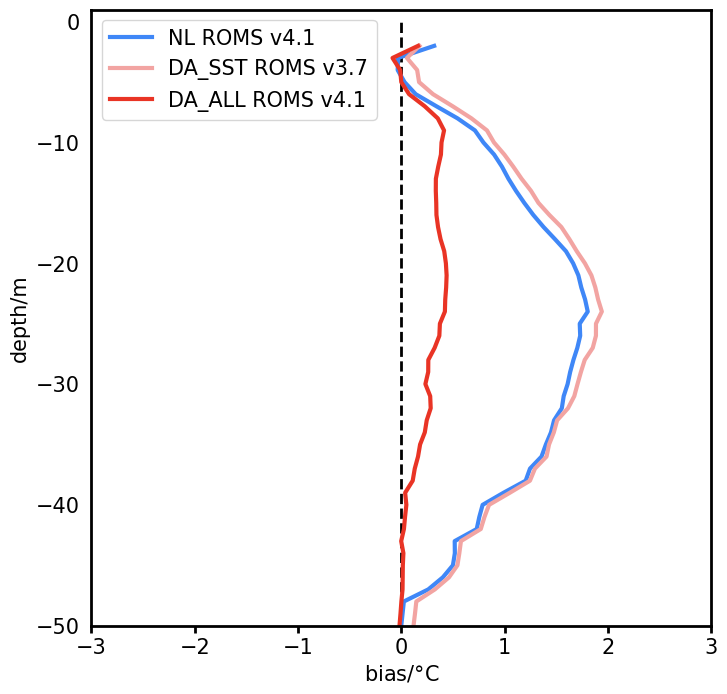

In [26]:
plt.style.use('default')
fig,ax = plt.subplots(figsize = (8,8))
for bnd in ax.spines.keys():
    ax.spines[bnd].set_linewidth('2')
ax.plot(np.nanmean(Fwd_errs,axis=1),depth_intplevel,color=my_palette[0], linewidth=3,label='NL ROMS v4.1',zorder=2)
ax.plot(np.nanmean(Prior_errs,axis=1),depth_intplevel,color=my_palette[7],linewidth=3,label='DA_SST ROMS v3.7',zorder=2)
ax.plot(np.nanmean(Post_errs,axis=1),depth_intplevel,color=my_palette[-1],linewidth=3,label='DA_ALL ROMS v4.1',zorder=2)
ax.plot(np.zeros_like(depth_intplevel),depth_intplevel,'--',color='k',linewidth=2,zorder=1)
ax.set_xlim([-3,3])
ax.set_ylim([-50,1])
ax.legend(loc='upper left',fontsize=15)
ax.set_ylabel('depth/m',fontsize=15)
ax.set_xlabel('bias/$\degree$C',fontsize=15)
ax.tick_params(direction = 'out',width =2,length=5, labelsize = 15,top = 0, right = 0,left=0)
# plt.savefig('/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS/dasst_bias.jpeg',bbox_inches='tight',dpi=400)

In [128]:
lon_obs,lat_obs

(array([122.42458803, 123.09839872, 123.90987608, ..., 126.4382521 ,
        126.52327603, 126.56637313]),
 array([[ 31.27411899, 123.09839872, 123.90987608, ..., 126.4382521 ,
         126.52327603, 126.56637313]]))

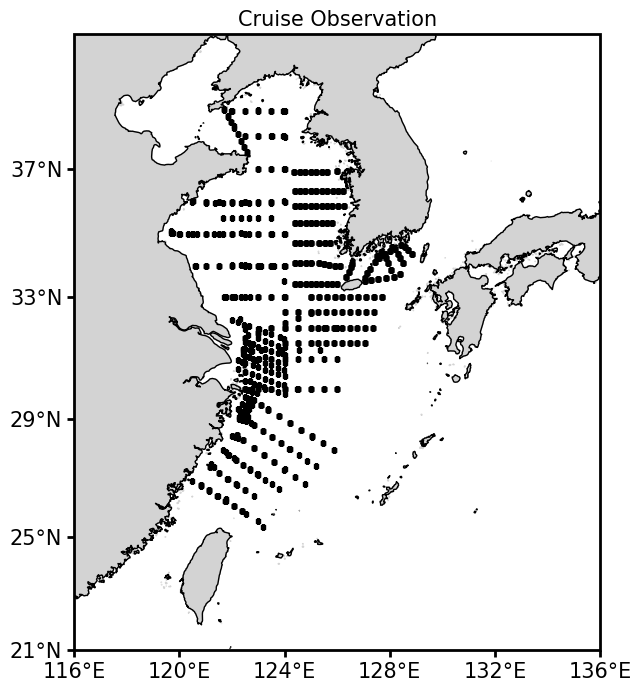

In [143]:
# %matplotlib
plt.style.use('default')
lon_bdy = [116,136];
lat_bdy = [21,41];
plt.rcParams['font.family'] = 'sans-serif'
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection = ccrs.Mercator())
for bnd in ax.spines.keys():
    ax.spines[bnd].set_linewidth('2')
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'k',zorder = 2,linewidth =1)
ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgrey',zorder = -1)
ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+4,4),crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1],4),crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(number_format='.0f',
                                degree_symbol='°',
                                dateline_direction_label=True)
lat_formatter = LatitudeFormatter(number_format='.0f',
                                    degree_symbol='°')
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.scatter(lon_obs,lat_obs.ravel(),10,'k',marker='s',transform = ccrs.PlateCarree(),)
ax.tick_params(direction = 'out',width =2,length=5, labelsize = 15,top = 0, right = 0)
ax.set_title('Cruise Observation',fontsize=15)
plt.savefig('/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS/obs_pos.jpeg',bbox_inches='tight',dpi=400)

In [ ]:
plt.plot(fwd_ds[model_var].isel(ocean_time=fwd_index,eta_rho=152,xi_rho=85),grid.depth_rho[:,152,85])

In [ ]:
fwd_profile

In [ ]:
depth_level

In [ ]:
fwddata_thistime